In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
import sisl
import ipyvolume as ipv

## Transistor de Grafeno
#### En este ejemplo crearemos los archivos de entrada para acoplar una nanocinta de grafeno a dos electrodos de oro. 

Para este ello haremos uso de la opción `sisl.geom.graphene()` de **sisl**, la cual con la opción `.tile()` crea repeticiones de la siguiente celda:


<img src="attachment:othogonal_uc_graphene.png" width="250"/>

In [2]:
graphene_device = sisl.geom.graphene(1.42, orthogonal=True).tile(4,axis=0).tile(3,axis=1)
graphene_device.write('graphene.xyz')
FileDev = 'graphene.xyz'

Con `sisl` hemos creado una nanocinta de Grafeno repitiendo 4 veces en *x* y 3 veces en *y*:


!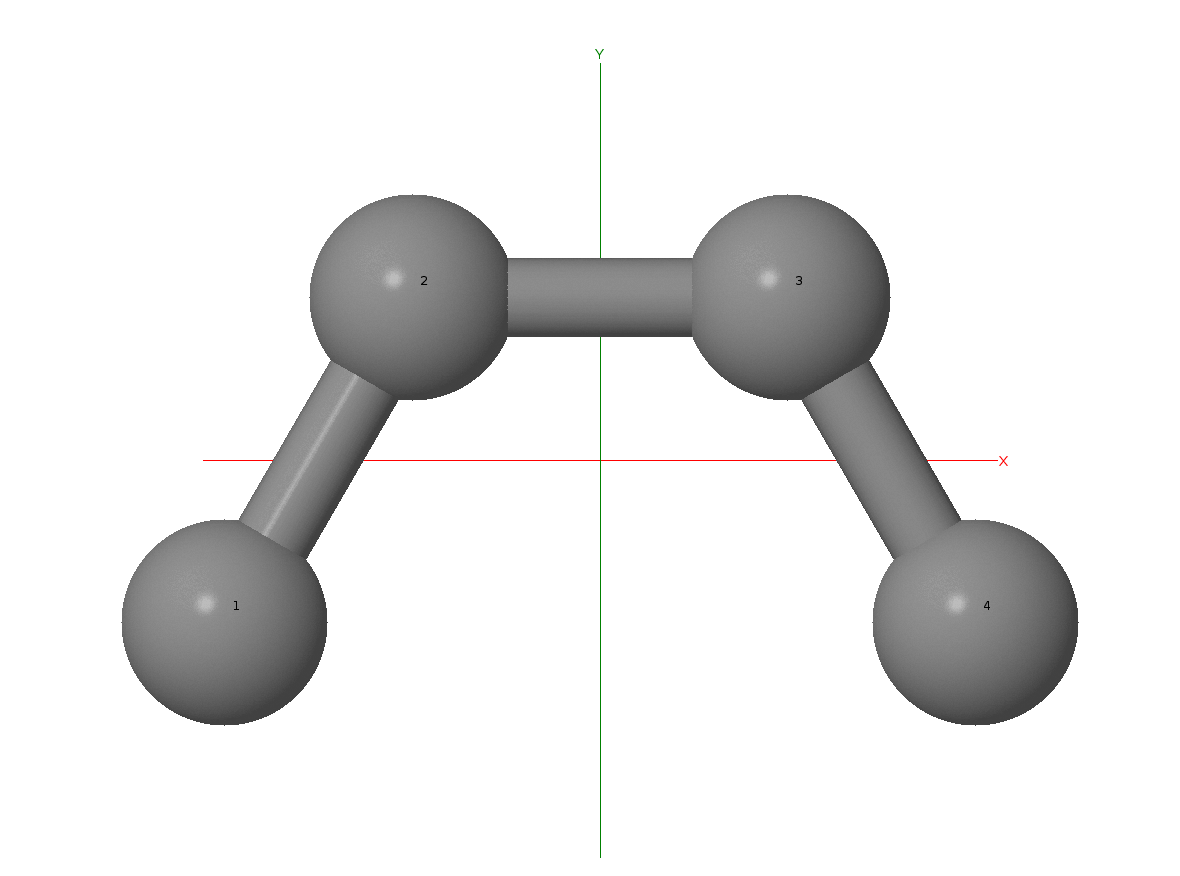

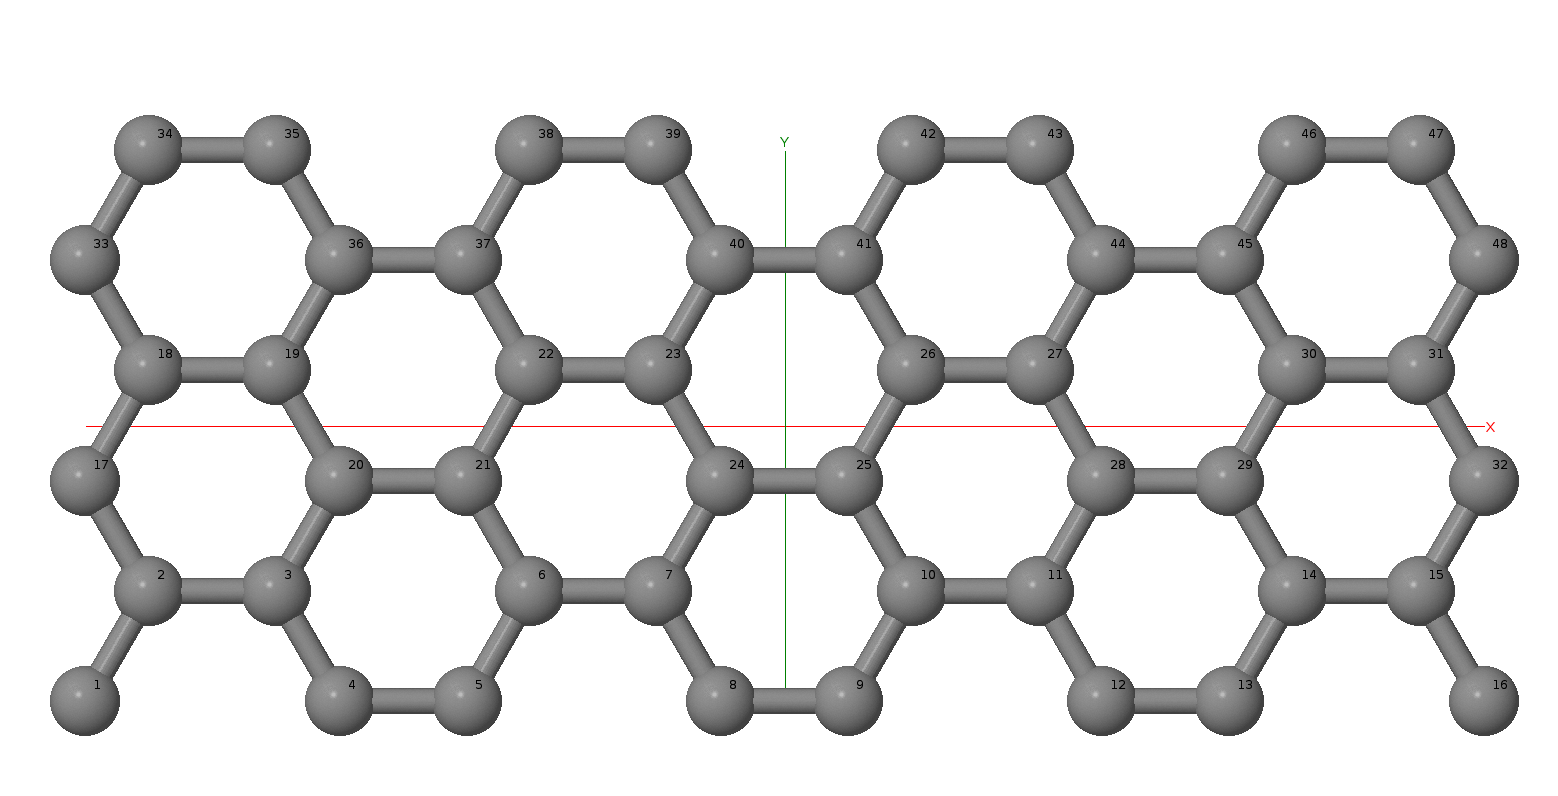!

Ahora leeremos de un archivo `.xyz` la geometría del electrodo y la almacenaremos en algunos arreglos para poder manipular su geometría (lo mismo haremos para el archivo `.xyz` del grafeno creado en el paso anterior):

In [3]:
def Readxyz(File):
    x,y,z    = loadtxt(File,usecols=(1,2,3),unpack=True,skiprows=2)
    atom     = loadtxt(File,usecols=(0,),unpack=True,skiprows=2,dtype="str")
    natoms   = len(x)
    Data     = {"label":File,
                "x":x,
                "y":y,
                "z":z,
                "atom":atom,
                "natoms":natoms}
    print ("System: ", File)
    print ("Número de átomos: {0}".format(natoms))
    print ("Tipos de atomos:",unique(atom))
    return Data

###########################        For Electrode  ##################################
FileElec = 'au_hcp48_electrode.xyz'
elec = Readxyz(FileElec)
elec_label = elec["label"].replace(".xyz","")
natoms_elec = elec["natoms"]
x_elec, y_elec, z_elec = elec["x"], elec["y"], elec["z"]
atoms_elec = elec["atom"]    
######################################################
xmax_elec, xmin_elec = np.amax(x_elec), np.amin(x_elec)
ymax_elec, ymin_elec = np.amax(y_elec), np.amin(y_elec)
zmax_elec, zmin_elec = np.amax(z_elec), np.amin(z_elec)
######################################################
Elec_leftXYZ = sisl.io.xyzSile(FileElec,mode='r')
Elec_elec    = Elec_leftXYZ.read_geometry()
Elec_elec.write("STRUCT_ELEC.fdf")
##########################    For Device  #########################################
dev = Readxyz(FileDev)
dev_label = dev["label"].replace(".xyz","")
natoms_dev = dev["natoms"]
x_dev, y_dev, z_dev = dev["x"], dev["y"], dev["z"]
atoms_dev = dev["atom"]    
###################################################################################
xmax_dev, xmin_dev = np.amax(x_dev), np.amin(x_dev)
ymax_dev, ymin_dev = np.amax(y_dev), np.amin(y_dev)
zmax_dev, zmin_dev = np.amax(z_dev), np.amin(z_dev)

System:  au_hcp48_electrode.xyz
Número de átomos: 48
Tipos de atomos: ['Au']
System:  graphene.xyz
Número de átomos: 48
Tipos de atomos: ['C']


##### Electrodo y Grafeno

!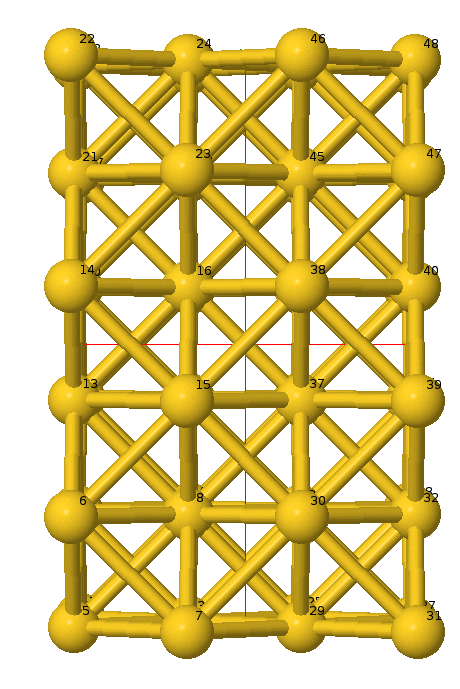 

### Creación de la región de scattering
La región de scattering es un sandwich: electrodo + dispositivo + electrodo:

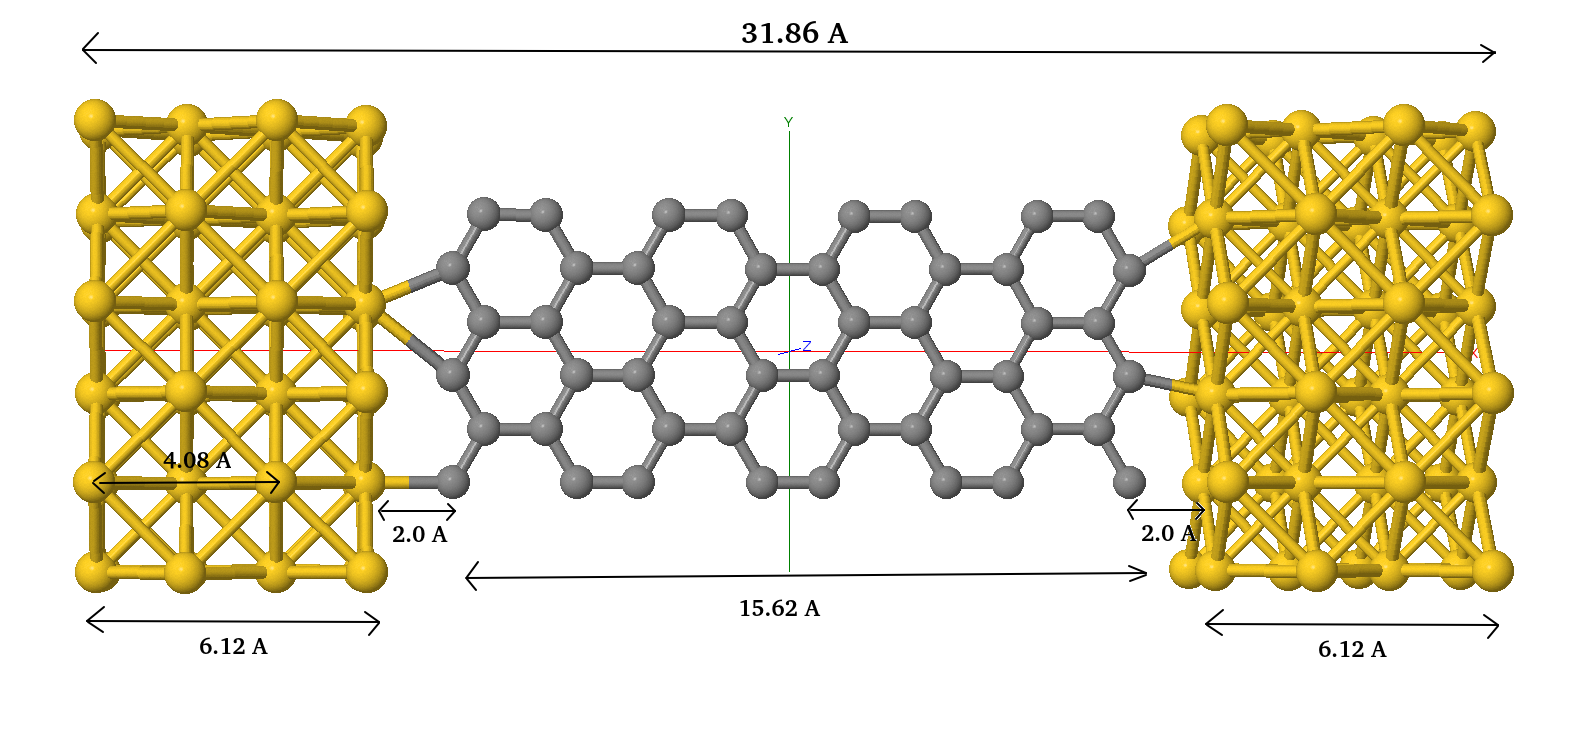  


Previo es es necesario definir la siguientes variables:

1.  `elec_atom_ref` : Indica la etiqueta de un átomo del electrodo: el dispositivo (grafeno) se orientará a con las coordenadas de ese átomo en el electrodo: `x_elec_ref`, `y_elec_ref` y `z_elec_ref`.

   
2. `x_dev_dis` es la distancia que habra entre el electrodo y el dispositivio.


3.  ` xt_dev`, `yt_dev`y `zt_dev` son las nuevas coordenadas del dispositivio ya trasladado a una distancia `x_dev_dis` del electrodo.


4. `a1_scatter`, `a2_scatter` y `a3_scatter` son los vectores de traslación que utilizará `Transiesta` para realizar la conexión de los electrodos con la región de scattering.

In [4]:
elec_atom_ref = 32
x_elec_ref, y_elec_ref, z_elec_ref = x_elec[elec_atom_ref-1], y_elec[elec_atom_ref-1],z_elec[elec_atom_ref-1]
x_dev_dis = 2.0  #### Device displacement with electrode
xt_dev = x_dev + xmax_elec + x_dev_dis
yt_dev = y_dev + y_elec_ref
zt_dev = z_dev + z_elec_ref
a1_scatter = [xmax_dev + 2*xmax_elec + 2*x_dev_dis + 4.08*0.5, 0.0 , 0.0]
a2_scatter = [0.0, 3*ymax_elec ,0.0]
a3_scatter = [0.0, 0.0, 3*zmax_elec]
lattice_vectors_scatter = "cell= " + str("{:.5f}".format(a1_scatter[0])) + " 0.00000 0.00000 " + "0.00000 " + str("{:.5f}".format(a2_scatter[1])) + " 0.00000" + " 0.00000 0.00000 " + str("{:.5f}".format(a3_scatter[2])) + " nsc= 1 1 1" + "\n"

Ahora sí creamos la región de scattering:

1. El primer loop es para el electrodo izquierdo, el segundo para la molécula y el tercero para el electrodo derecho.


2. Al final se hace uso de `sisl` para transformar la geometría de la región de scattering de un formato `.xyz` a un formato `.fdf` el cuál puede leer SIESTA.

In [5]:
natoms_scatter = 2*natoms_elec + natoms_dev
scatter_file = str(elec_label)+ "_" +str(dev_label)+".xyz"
scatter = open(str(elec_label)+ "_" +str(dev_label)+".xyz","w")
scatter.write(str(natoms_scatter) + "\n")
scatter.write(lattice_vectors_scatter)
for atom in range(natoms_elec):
    scatter.write(str(atoms_elec[atom]) + "  " + str("{:.5f}".format(x_elec[atom])) + "  " +str("{:.5f}".format(y_elec[atom])) + "  " +str("{:.5f}".format(z_elec[atom])) + "\n")
for atom in range(natoms_dev):
    scatter.write(str(atoms_dev[atom]) + "  " + str("{:.5f}".format(xt_dev[atom])) + "  " +str("{:.5f}".format(yt_dev[atom])) + "  " +str("{:.5f}".format(zt_dev[atom])) + "\n")
for atom in range(natoms_elec):
    x_elec_r = xmax_elec + xmax_dev + 2*x_dev_dis + x_elec[atom] 
    scatter.write(str(atoms_elec[atom]) + "  " + str("{:.5f}".format(x_elec_r)) + "  " +str("{:.5f}".format(y_elec[atom])) + "  " +str("{:.5f}".format(z_elec[atom])) + "\n")
scatter.close()
scatter_xyz = sisl.io.xyzSile(scatter_file,mode='r')
scatter    = scatter_xyz.read_geometry()
scatter.write("STRUCT_DEVICE.fdf")

In [7]:
exit()